# starfuSED: Complete Usage Examples

This notebook demonstrates the functionality of the `starfused` package for SED fitting of stars and binary systems.

In [1]:
import pprint
import starfused as sf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import corner
import warnings
warnings.filterwarnings('ignore')


plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

---
## 1. Photometry Queries

Query photometric data from the VizieR SED service by object name or coordinates.

### Query by Source Name

In [2]:
# Query photometry using a Gaia DR3 source ID
phot_data = sf.Photometry.query(
    name="TIC 124573902",
    filters=['GALEX','UVOT', 'Gaia', '2MASS','WISE','SDSS'],
    radius=3  # Search radius in arcseconds
).query('sed_wave < 115595') # remove W3 and W4

print(f"Retrieved {len(phot_data)} photometric measurements")
phot_data[['sed_filter', 'sed_wave', 'sed_flux', 'sed_eflux']]

Retrieved 12 photometric measurements


,sed_filter,sed_wave,sed_flux,sed_eflux
0,GALEX:NUV,2312.0,2.097635e-15,5.047785e-17
1,SDSS:u,3519.0,1.934299e-15,9.683602e-18
2,SDSS:g,4820.0,8.723261e-16,5.161692e-18
3,SDSS:r,6247.0,3.940925e-16,7.682115e-19
4,Gaia:G,6730.0,3.455153e-16,5.456728e-18
5,SDSS:i,7635.0,2.211470e-16,1.028591e-18
6,SDSS:z,9018.0,1.581478e-16,7.372857e-19
7,2MASS:J,12390.0,1.103354e-16,6.792940e-19
8,2MASS:H,16495.0,5.520340e-17,1.558261e-19
9,2MASS:Ks,21638.0,1.850505e-17,2.943003e-18


### Query by Coordinates

In [3]:
# Query using RA/Dec coordinates (in degrees)
phot_coords = sf.Photometry.query(
    ra=223.82008,
    dec=-2.05765, 
    filters=['SDSS', 'Gaia', '2MASS'],
    radius=2 # arcseconds
)

print(f"Found {len(phot_coords)} measurements at (223.82008, -2.05765)")

Found 12 measurements at (223.82008, -2.05765)


### Visualize Raw Photometry

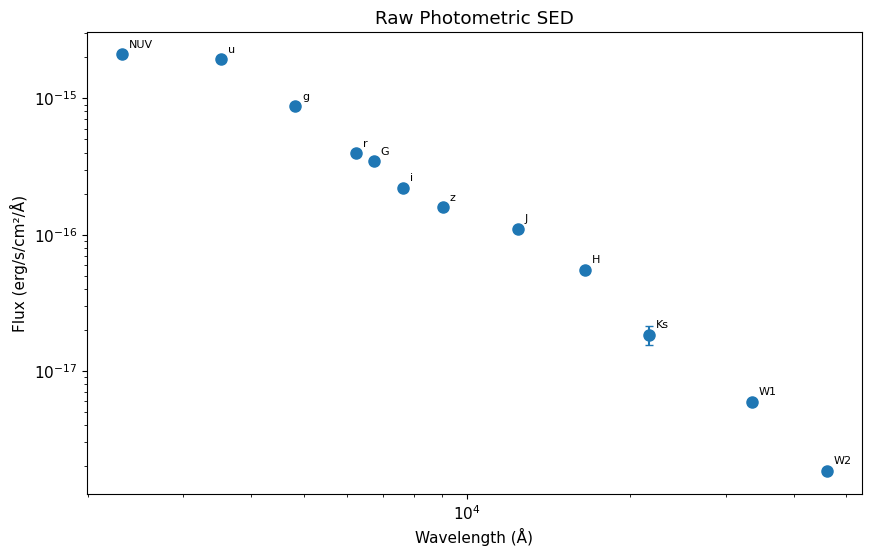

In [4]:
plt.figure(figsize=(10, 6))
plt.errorbar(
    phot_data['sed_wave'], 
    phot_data['sed_flux'], 
    yerr=phot_data['sed_eflux'], 
    fmt='o', 
    capsize=3,
    markersize=8
)

# Label the filters
for _, row in phot_data.iterrows():
    plt.annotate(
        row['sed_filter'].split(':')[-1], 
        (row['sed_wave'], row['sed_flux']),
        textcoords='offset points', 
        xytext=(5, 5), 
        fontsize=8
    )

plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (erg/s/cm²/Å)')
plt.xscale('log')
plt.yscale('log')
plt.title('Raw Photometric SED')
plt.show()

---
## 2. Dust Extinction Correction

Correct photometry for interstellar dust extinction using E(B-V) from IRSA and extinction curves from STScI.

In [5]:
# Apply Milky Way dust correction using Schlafly & Finkbeiner dust map
phot_corrected = sf.Photometry.dust_correction(
    phot_data,
    extinction='mw',      # Milky Way diffuse extinction curve
    dustmap='SandF'       # Schlafly & Finkbeiner (2011) dust map
)

Retrived E(B-V) = 0.042 from SandF dust map.


### Compare Original vs. Dust-Corrected

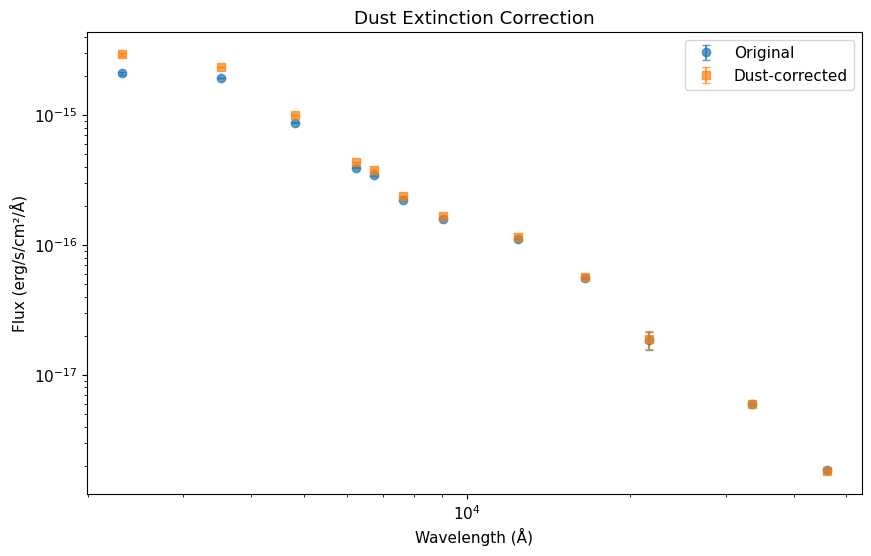

In [6]:
plt.figure(figsize=(10, 6))

plt.errorbar(
    phot_data['sed_wave'], phot_data['sed_flux'], 
    yerr=phot_data['sed_eflux'], 
    fmt='o', label='Original', alpha=0.7, capsize=3
)
plt.errorbar(
    phot_corrected['sed_wave'], phot_corrected['sed_flux'], 
    yerr=phot_corrected['sed_eflux'], 
    fmt='s', label='Dust-corrected', alpha=0.7, capsize=3
)

plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (erg/s/cm²/Å)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Dust Extinction Correction')
plt.show()

---
## 3. Stellar Atmosphere Models

Load stellar atmosphere models from four different grids.

### Castelli-Kurucz 2004 (CK04)
Best for main-sequence F/G/K stars.

In [7]:
# Load a solar-type star model
ck_model = sf.StellarModel(grid='ck04')
ck_spectrum = ck_model.load_model(teff=5750, logg=4.5, metallicity=0.0)

print(f"Loaded spectrum with {len(ck_spectrum)} wavelength points")
ck_spectrum.tail()

Loading model: Teff=5750K, log_g=4.5, [M/H]=0.0
Loaded spectrum with 1221 wavelength points


,wavelength,flux
1216,800000.0,0.27830
1217,1000000.0,0.11330
1218,1200000.0,0.05437
1219,1400000.0,0.02921
1220,1600000.0,0.01705


### PHOENIX Models
Better for cool stars and M dwarfs due to improved molecular opacities.

In [8]:
# Load an M dwarf model
phoenix_model = sf.StellarModel(grid='phoenix')
phoenix_spectrum = phoenix_model.load_model(teff=3500, logg=5.0, metallicity=0.0)

print(f"Loaded PHOENIX spectrum with {len(phoenix_spectrum)} wavelength points")

Loading model: Teff=3500K, log_g=5.0, [M/H]=0.0
Loaded PHOENIX spectrum with 103000 wavelength points


### Koester White Dwarf Models
Pure hydrogen (DA) white dwarf atmospheres.

In [9]:
# Load a white dwarf model
koester_model = sf.StellarModel(grid='koester')
koester_spectrum = koester_model.load_model(teff=15000, logg=8.0, metallicity=None)

print(f"Loaded Koester WD spectrum with {len(koester_spectrum)} wavelength points")

Loading model: Teff=15000K, log_g=8.0
Loaded Koester WD spectrum with 4285 wavelength points


### BT-Settl Models
For brown dwarfs and very cool objects (includes cloud/dust physics).

In [10]:
# Load a brown dwarf model
btsettl_model = sf.StellarModel(grid='bt-settl')
btsettl_spectrum = btsettl_model.load_model(teff=2000, logg=5.0, metallicity=0.0)

print(f"Loaded BT-Settl spectrum with {len(btsettl_spectrum)} wavelength points")

Loading model: Teff=2000K, log_g=5.0, [M/H]=0.0
Loaded BT-Settl spectrum with 381075 wavelength points


### Compare Model Spectra

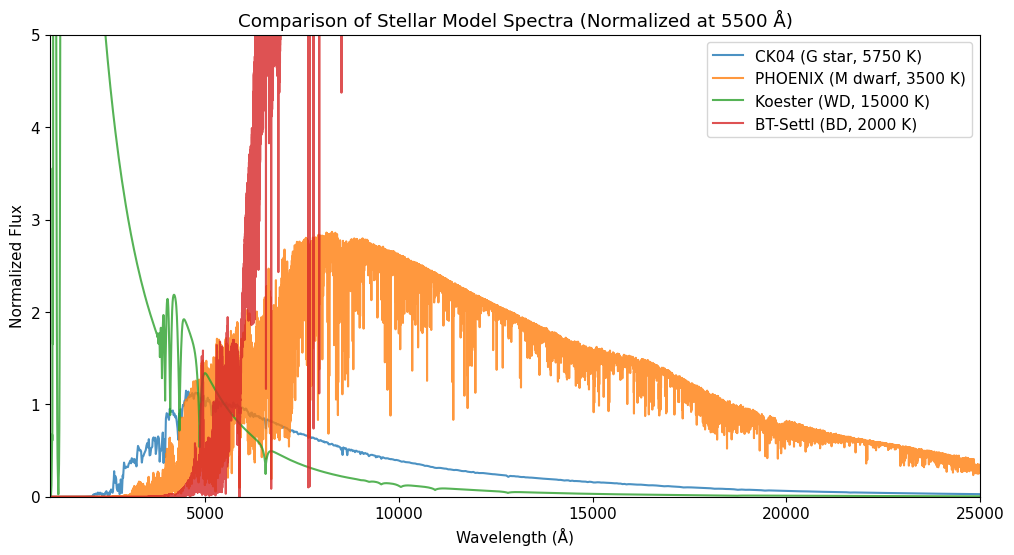

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

def normalize_at(spec, wave_norm=5500):
    norm_flux = np.interp(wave_norm, spec['wavelength'], spec['flux'])
    return spec['flux'] / norm_flux

ax.plot(ck_spectrum['wavelength'], normalize_at(ck_spectrum), 
        label='CK04 (G star, 5750 K)', alpha=0.8)
ax.plot(phoenix_spectrum['wavelength'], normalize_at(phoenix_spectrum), 
        label='PHOENIX (M dwarf, 3500 K)', alpha=0.8)
ax.plot(koester_spectrum['wavelength'], normalize_at(koester_spectrum), 
        label='Koester (WD, 15000 K)', alpha=0.8)
ax.plot(btsettl_spectrum['wavelength'], normalize_at(btsettl_spectrum), 
        label='BT-Settl (BD, 2000 K)', alpha=0.8)

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Normalized Flux')
ax.set_xlim(1000, 25000)
ax.set_ylim(0, 5)
ax.legend()
ax.set_title('Comparison of Stellar Model Spectra (Normalized at 5500 Å)')
plt.show()

### Find Closest Model Parameters

In [12]:
# Find the closest available model to requested parameters
model = sf.StellarModel(grid='ck04')
params = model.find_model(teff=5800, logg=4.3, metallicity=0.1)

print("Requested: Teff=5800 K, log g=4.3, [M/H]=0.1")
print(f"Closest available: Teff={params['teff']} K, log g={params['logg']}, [M/H]={params['metallicity']}")

Requested: Teff=5800 K, log g=4.3, [M/H]=0.1
Closest available: Teff=5750 K, log g=4.3, [M/H]=0.0


---
## 4. Single Star SED Fitting

Fit photometry to a single stellar model.

### Basic Fitting

In [ ]:
# Define the parameter search space
params = {
    'modelname': 'koester',       
    'teff_min': 5000,
    'teff_max': 15000,
    'teff_step':250,
    'logg_min': 7.0,
    'logg_max': 9.5,
    'logg_step': 0.25,
    'metallicity': None,         
    'norm_band': 'NUV'           
}

fitter = sf.SingleSEDFitter(
    phot_corrected, 
    distance_pc=169.2, 
    source_params=params
)

# Adaptive fitting with 2 refinement iterations
result_adaptive = fitter.fit_adaptive(
    n_refine=2,
    refine_factor=4,
    coarse_factor=4
)

Coarse grid: 11 Teff x 3 logg
Loading model: Teff=5000K, log_g=7.0
Loading model: Teff=5000K, log_g=8.0
Loading model: Teff=5000K, log_g=9.0
Loading model: Teff=6000K, log_g=7.0
Loading model: Teff=6000K, log_g=8.0
Loading model: Teff=6000K, log_g=9.0
Loading model: Teff=7000K, log_g=7.0
Loading model: Teff=7000K, log_g=8.0
Loading model: Teff=7000K, log_g=9.0
Loading model: Teff=8000K, log_g=7.0
Loading model: Teff=8000K, log_g=8.0
Loading model: Teff=8000K, log_g=9.0
Loading model: Teff=9000K, log_g=7.0
Loading model: Teff=9000K, log_g=8.0
Loading model: Teff=9000K, log_g=9.0
Loading model: Teff=10000K, log_g=7.0
Loading model: Teff=10000K, log_g=8.0
Loading model: Teff=10000K, log_g=9.0
Loading model: Teff=11000K, log_g=7.0
Loading model: Teff=11000K, log_g=8.0
Loading model: Teff=11000K, log_g=9.0
Loading model: Teff=12000K, log_g=7.0
Loading model: Teff=12000K, log_g=8.0
Loading model: Teff=12000K, log_g=9.0
Loading model: Teff=13000K, log_g=7.0
Loading model: Teff=13000K, log_g=8

### Plot the Result

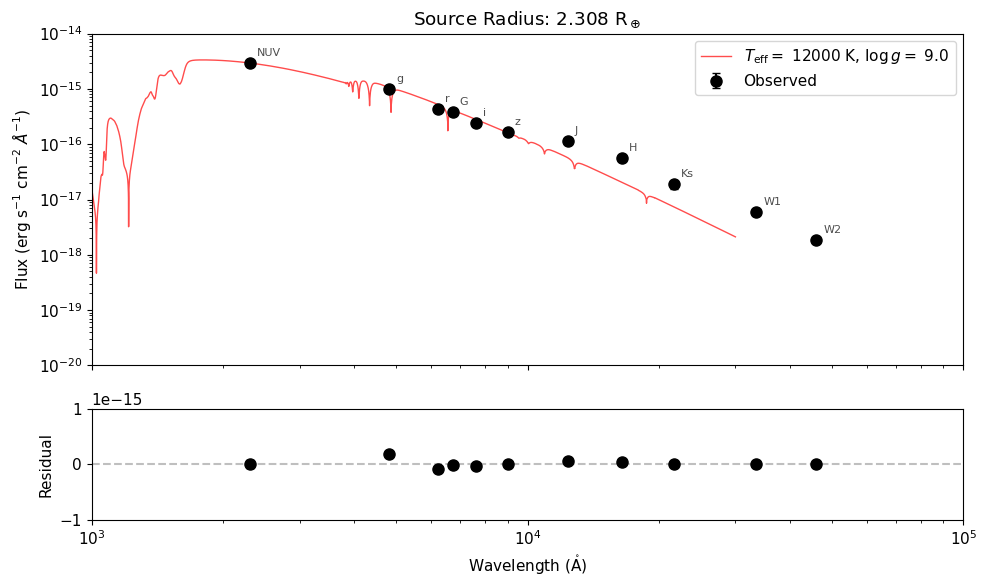

In [14]:
title = fr'Source Radius: {result_adaptive["radius_rearth"]:.3f} R$_\oplus$'
label = r'$T_{\rm eff} =$'+f' {result_adaptive["teff"]} K,' + r' $\log g = $'+f' {result_adaptive["logg"]} '


fig, axes = sf.plot_single_sed(
    result_adaptive, 
    phot_corrected.query('sed_filter != "SDSS:u"'),
    show_residuals=True,
    show_filter_labels=True,
    ylim=(1e-20, 1e-14),
    title=title,
    figsize=(10, 6),
    source_label=label,
    residual_mode='offset',
    residual_offset=1e-15
)
plt.tight_layout()
plt.show()

In [15]:
pprint.pprint(result_adaptive)

{'chi2': np.float64(77718.89475008052),
 'distance_pc': 169.2,
 'logg': np.float64(9.0),
 'metallicity': None,
 'model_flux': array([2.93273805e-15, 1.52769239e-15, 8.20937008e-16, 5.17036617e-16,
       4.00087472e-16, 2.78535192e-16, 1.60480118e-16, 5.64154399e-17,
       2.03209269e-17, 7.40778053e-18, 1.38171993e-18, 4.07041368e-19]),
 'n_data': 12,
 'n_params': 1,
 'norm': np.float64(7.947779377661353e-24),
 'radius_rearth': np.float64(2.307716638607558),
 'radius_rjup': np.float64(0.20588104253207162),
 'radius_rsun': np.float64(0.021156888734659863),
 'reduced_chi2': np.float64(7065.354068189138),
 'spectrum':       wavelength       flux
0        899.230    9661.53
1        899.266    9667.28
2        901.750   10076.20
3        904.235   10499.60
4        906.720   10938.10
...          ...        ...
5005   29805.549  272442.00
5006   29883.873  269679.00
5007   29932.600  267977.00
5008   29962.196  266950.00
5009   29991.792  265928.00

[5010 rows x 2 columns],
 'teff': 1200

---
## 5. Binary System SED Fitting

Fit a binary system with two stellar components (e.g., white dwarf + M dwarf).

### Define Binary Parameters

In [16]:
# Source 1: Hot component (white dwarf), dominates in UV
source1_params = {
    'modelname': 'koester',       
    'teff_min': 5000,
    'teff_max': 15000,
    'teff_step':250,
    'logg_min': 7.0,
    'logg_max': 9.5,
    'logg_step': 0.25,
    'metallicity': None,         
    'norm_band': 'NUV'           
}

# Source 2: Cool component, dominates in IR

source2_params = {
    'modelname': 'bt-settl',
    'teff_min': 2500,
    'teff_max': 4000,
    'teff_step': 100,
    'logg_min': 4.5,
    'logg_max': 5.5,
    'logg_step': 0.5,
    'metallicity': 0.0,
    'norm_band': None
}

### Fit the Binary System

In [17]:
fitter = sf.BinarySEDFitter(
    phot_corrected,
    distance_pc=169.2,  
    source1_params=source1_params,
    source2_params=source2_params,
    verbose=False
)

binary_result = fitter.fit_adaptive(n_refine=4, coarse_factor=4)

### Plot Binary SED with Components

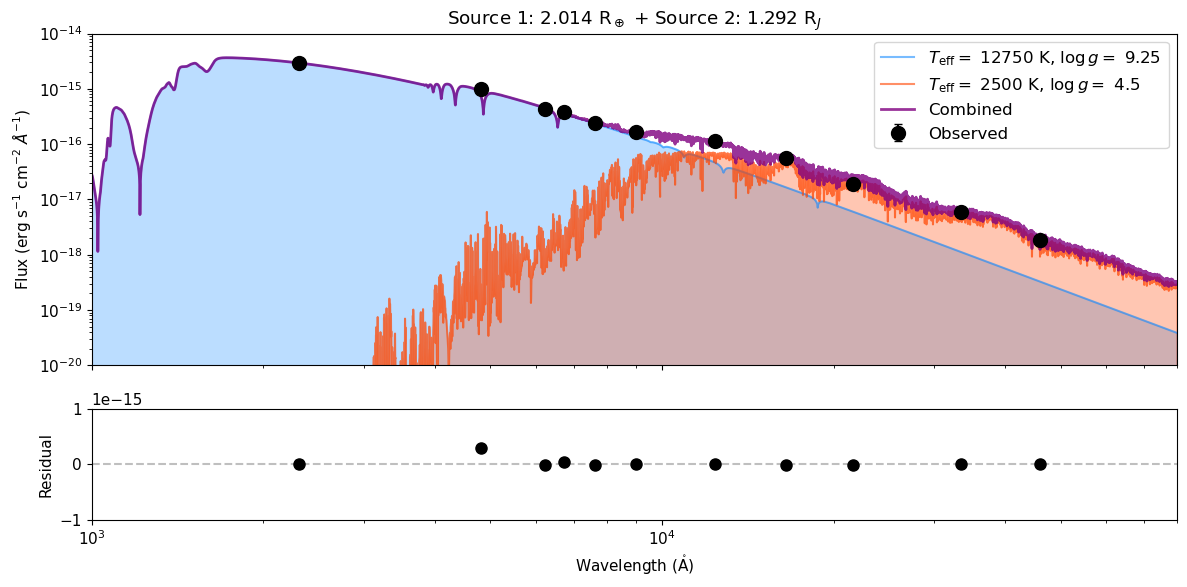

In [18]:
title = fr'Source 1: {binary_result["source1"]["radius_rearth"]:.3f} R$_\oplus$ + Source 2: {binary_result["source2"]["radius_rjup"]:.3f} R$_J$'

label1 = r'$T_{\rm eff} =$'+f' {binary_result["source1"]["teff"]} K,' + r' $\log g = $'+f' {binary_result["source1"]["logg"]} '

label2 = r'$T_{\rm eff} =$'+f' {binary_result["source2"]["teff"]} K,' + r' $\log g = $'+f' {binary_result["source2"]["logg"]} '

fig, (ax1, ax2) = sf.plot_binary_sed(
    binary_result,
    phot_corrected.query('sed_filter != "SDSS:u"'),
    title=title,
    source1_label=label1,
    source2_label= label2,
    source1_color='dodgerblue',
    source2_color='orangered',
    combined_color='purple',
    xlim=(1000, 80000),
    ylim=(1e-20, 1e-14),
    show_filter_labels=False,
    fill_under=True,
    figsize=(12, 6),
    residual_mode='offset',
    residual_offset=1e-15
)


ax1.legend(fontsize=12).set_visible(True)
plt.tight_layout()
plt.show()

### Examine Binary Results

In [19]:
pprint.pprint(binary_result)

{'chi2': np.float64(9447.828326959134),
 'combined_flux': array([2.93273805e-15, 1.41817146e-15, 7.05697028e-16, 4.44546438e-16,
       3.40325797e-16, 2.46506173e-16, 1.83908021e-16, 1.05995191e-16,
       5.59859715e-17, 2.31858501e-17, 6.23812813e-18, 1.80716650e-18]),
 'distance_pc': 169.2,
 'n_data': 12,
 'n_params': 4,
 'reduced_chi2': np.float64(1180.9785408698917),
 'source1': {'logg': np.float64(9.25),
             'metallicity': None,
             'norm': np.float64(6.0541454535551494e-24),
             'radius_rearth': np.float64(2.0141230760205358),
             'radius_rjup': np.float64(0.17968833423553093),
             'radius_rsun': np.float64(0.018465255700972513),
             'spectrum':       wavelength      flux
0        899.230   29790.0
1        901.469   30815.0
2        902.853   31462.4
3        904.235   32121.5
4        904.762   32375.4
...          ...       ...
4891   29805.549  288892.0
4892   29883.873  285952.0
4893   29932.600  284140.0
4894   29962.1

#### Compute Fit Uncertainties via Monte Carlo

In [20]:
result = fitter.fit_mc(n_iter=100000, sigma_clip=3, seed=42)

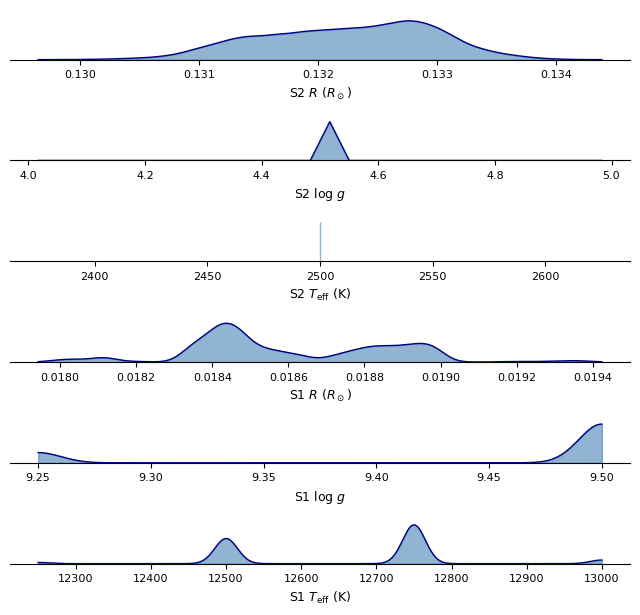

In [21]:
fig, axes = sf.plot_mc_ridgeline(result)

---
## Summary

This notebook demonstrated the core functionality of *starfuSED*:

1. **Photometry.query()** - Retrieve photometry from VizieR by name or coordinates
2. **Photometry.dust_correction()** - Correct for interstellar extinction
3. **StellarModel** - Load spectra from CK04, PHOENIX, Koester, or BT-Settl grids
4. **SingleSEDFitter** - Fit single stars with chi-squared minimization
5. **BinarySEDFitter** - Fit binary systems with two components
6. **plot_single_sed() / plot_binary_sed()** - Create publication-ready plots

For more details, see the [documentation](https://starfused.readthedocs.io/).